# Single models

## Decision Tree

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
class ModelManager:
    def __init__(self, train_data, test_data, features_to_keep, window_size, target_step):
        self.train_data = train_data
        self.test_data = test_data
        self.features_to_keep = features_to_keep
        self.window_size = window_size
        self.target_step = target_step
        self.models = {}  # Store trained models
        self.results = {}  # Store results like y_pred for each model
    
    def create_sliding_window(self, data):
        X, y = [], []
        for i in range(len(data) - self.window_size - self.target_step):
            X.append(data.iloc[i:i+self.window_size, 1:].values.flatten())  
            y.append(data['Load'].iloc[i+self.window_size+self.target_step])  
        return np.array(X), np.array(y)
    
    def preprocess_data(self):
        X_train, y_train = self.create_sliding_window(self.train_data)
        X_test, y_test = self.create_sliding_window(self.test_data)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test
    
    def train_model(self, model_name, param_dist, n_estimators, random_state, X_train, y_train):
        tree_model = DecisionTreeRegressor(random_state=random_state)
        bagging_tree = BaggingRegressor(estimator=tree_model, n_estimators=n_estimators, random_state=random_state, n_jobs=-1)
        random_search_tree = RandomizedSearchCV(
            bagging_tree, param_distributions=param_dist, n_iter=80,
            scoring='neg_mean_squared_error', cv=3, verbose=1, random_state=random_state, n_jobs=-1
        )
        random_search_tree.fit(X_train, y_train)
        self.models[model_name] = random_search_tree.best_estimator_
        return random_search_tree.best_estimator_
    
    def predict(self, model_name, X_test, y_test):
        model = self.models.get(model_name)
        if not model:
            raise ValueError(f"Model '{model_name}' is not trained yet.")
        
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        self.results[model_name] = {
            "y_pred": y_pred,
            "metrics": {
                "MSE": mse,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2,
                "MAPE": mape
            }
        }
    
    def plot_results(self, model_name, y_test):
        y_pred = self.results[model_name]["y_pred"]
        plt.figure(figsize=(8, 3))
        plt.plot(y_test, label='Actual', linewidth=2)
        plt.plot(y_pred, label='Predicted', linestyle='--')
        plt.legend()
        plt.xlabel("Time (15-min interval)")
        plt.ylabel("Load (kW)")
        plt.title(f"Actual vs Predicted Load - {model_name}")
        plt.grid()
        plt.show()
    
    def summarize_results(self):
        summary = pd.DataFrame([
            {
                "Model": model_name,
                **self.results[model_name]["metrics"]
            }
            for model_name in self.results.keys()
        ])
        print(summary)
        return summary

Fitting 3 folds for each of 80 candidates, totalling 240 fits


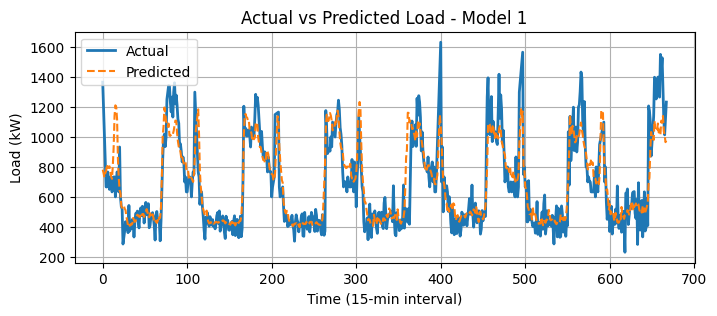

Fitting 3 folds for each of 80 candidates, totalling 240 fits


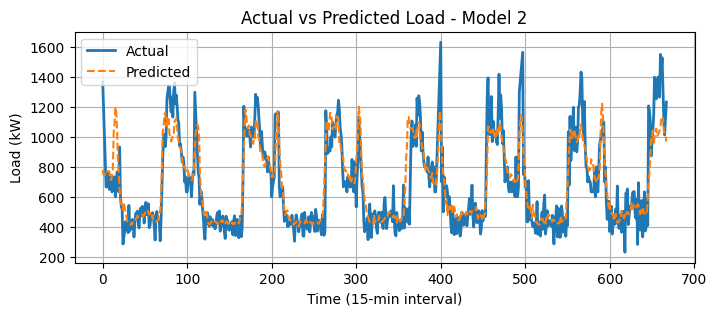

Fitting 3 folds for each of 80 candidates, totalling 240 fits


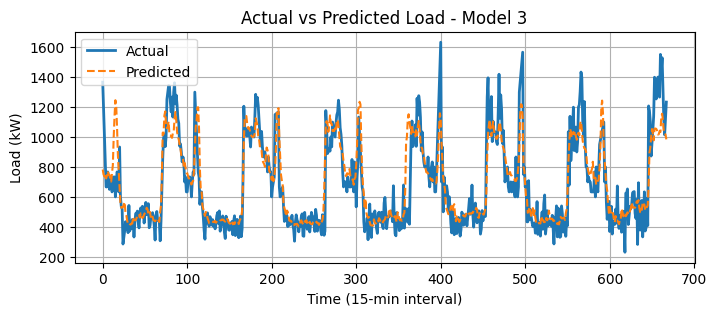

Fitting 3 folds for each of 80 candidates, totalling 240 fits


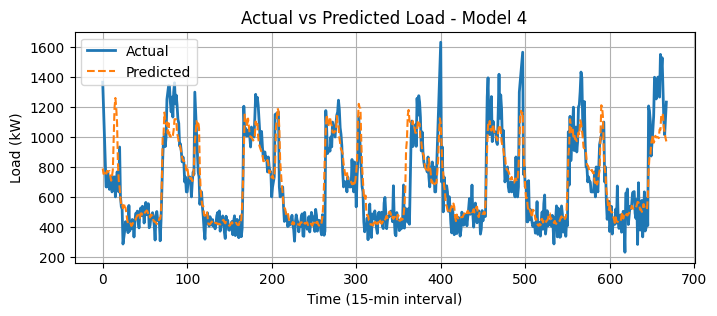

Fitting 3 folds for each of 80 candidates, totalling 240 fits


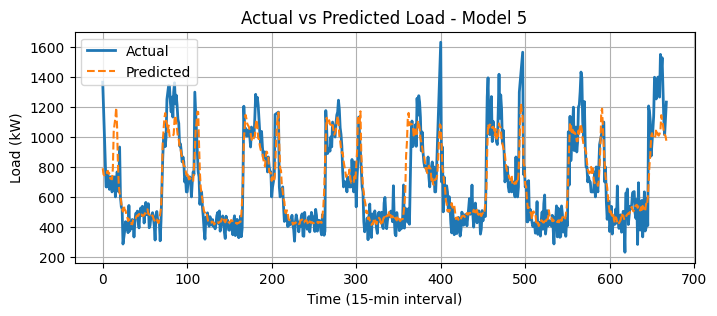

     Model           MSE        RMSE         MAE        R2       MAPE
0  Model 1  22260.103787  149.198203  103.390647  0.756913  15.848956
1  Model 2  21584.442597  146.916448  101.593616  0.764291  15.709363
2  Model 3  21681.697394  147.247062  100.717267  0.763229  15.572156
3  Model 4  21799.147502  147.645344  100.892061  0.761947  15.591288
4  Model 5  21164.005502  145.478540   99.407633  0.768882  15.319874


In [2]:

if __name__ == "__main__":
    # Load data
    train_data = pd.read_csv("train_delta_o.csv")
    test_data = pd.read_csv("test_delta_o.csv")
    
    features_to_keep = ['Load','D_1','D_2','D_3','D_4','D_5','D_6','D_7','Pc_1','Pc_2','Pc_3','Pc_4','Pc_5','Pc_6','Pc_7',
                        'relative_humidity', 'clearsky_dni','zenith',
                        'Day','Month','D_1_h','D_2_h','D_3_h',
                        'uv_index','dewpoint_temp','Hour','Minute']
    train_data = train_data[features_to_keep]
    test_data = test_data[features_to_keep]

    # Initialize manager
    manager = ModelManager(train_data, test_data, features_to_keep, window_size=4, target_step=0)
    X_train, X_test, y_train, y_test = manager.preprocess_data()

    # Model 1
    param_dist1 = {
        'estimator__max_depth': (2, 70),
        'estimator__min_samples_split': [2, 3, 4, 5, 6],
        'estimator__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9],
        'estimator__splitter': ['best', 'random'],
        'estimator__criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
        'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9]
    }
    manager.train_model("Model 1", param_dist1, n_estimators=40, random_state=76, X_train=X_train, y_train=y_train)
    manager.predict("Model 1", X_test, y_test)
    manager.plot_results("Model 1", y_test)

    # Model 2
    param_dist2 = {
        'estimator__max_depth': (2, 80),
        'estimator__min_samples_split': [2, 9],
        'estimator__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9],
        'estimator__splitter': ['best', 'random'],
        'estimator__criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
        'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9]
    }
    manager.train_model("Model 2", param_dist2, n_estimators=50, random_state=57, X_train=X_train, y_train=y_train)
    manager.predict("Model 2", X_test, y_test)
    manager.plot_results("Model 2", y_test)

    # Model 3
    param_dist3 = {
        'estimator__max_depth': (2, 80),
        'estimator__min_samples_split': [2, 3, 4, 5],
        'estimator__min_samples_leaf': [2, 3, 4, 5, 6],
        'estimator__splitter': ['best', 'random'],
        'estimator__criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
        'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9]
    }

    manager.train_model("Model 3", param_dist3, n_estimators=70, random_state=65, X_train=X_train, y_train=y_train)
    manager.predict("Model 3", X_test, y_test)
    manager.plot_results("Model 3", y_test)
     # Model 4
    param_dist4 = {
    'estimator__max_depth': (2,70),
    'estimator__min_samples_split': (2,3,4,5),
    'estimator__min_samples_leaf': [2, 3, 4, 5, 6],
    'estimator__splitter': ['best', 'random'],
    'estimator__criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
    'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9]
    }
    manager.train_model("Model 4", param_dist4, n_estimators=60, random_state=60, X_train=X_train, y_train=y_train)
    manager.predict("Model 4", X_test, y_test)
    manager.plot_results("Model 4", y_test)
    # Model 5
    param_dist5 = {
    'estimator__max_depth': (2,90),
    'estimator__min_samples_split': (2,3,4,5,6,7,8),
    'estimator__min_samples_leaf': [2, 3, 4, 5, 6,7],
    'estimator__splitter': ['best', 'random'],
    'estimator__criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
    'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9]
}
    manager.train_model("Model 5", param_dist5, n_estimators=50, random_state=74, X_train=X_train, y_train=y_train)
    manager.predict("Model 5", X_test, y_test)
    manager.plot_results("Model 5", y_test)
    # Summarize all results
    manager.summarize_results()


**Decision Tree - Test**

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Decision Tree Regressor Results:
MSE: 24375.3170
RMSE: 156.1260
MAE: 107.9035
R2: 0.7338
Explained Variance: 0.7343
MAPE: 15.8820


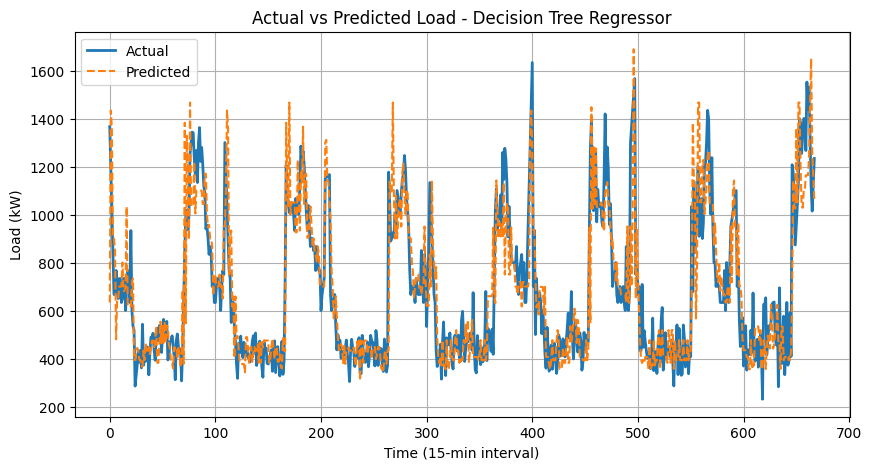

In [7]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class ModelManager:
    def __init__(self, train_data, test_data, features_to_keep, window_size, target_step):
        self.train_data = train_data
        self.test_data = test_data
        self.features_to_keep = features_to_keep
        self.window_size = window_size
        self.target_step = target_step
        self.models = {}
        self.results = {}

    def create_rolling_features(self, data, roll_window=4):
        """
        Ví dụ thêm: tính rolling mean và rolling std cho cột 'Load'.
        Có thể mở rộng cho các cột khác.
        """
        data = data.copy()
        data['Load_roll_mean'] = data['Load'].rolling(window=roll_window).mean()
        data['Load_roll_std'] = data['Load'].rolling(window=roll_window).std()
        data.fillna(method='bfill', inplace=True)
        return data

    def create_sliding_window(self, data):
        """
        Tạo sliding window để lấy các input X và target y.
        """
        X, y = [], []
        for i in range(len(data) - self.window_size - self.target_step):
            # Giả sử cột đầu tiên là time stamp, lấy dữ liệu từ cột thứ 2 (index=1) trở đi.
            X.append(data.iloc[i:i+self.window_size, 1:].values.flatten())  
            y.append(data['Load'].iloc[i+self.window_size+self.target_step])  
        return np.array(X), np.array(y)

    def preprocess_data(self):
        # Thêm rolling features
        self.train_data = self.create_rolling_features(self.train_data)
        self.test_data = self.create_rolling_features(self.test_data)

        # Tạo X, y theo sliding window
        X_train, y_train = self.create_sliding_window(self.train_data)
        X_test, y_test = self.create_sliding_window(self.test_data)

        # Chuẩn hoá dữ liệu
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test

    def train_model(self, model_name, model, param_dist, random_state, X_train, y_train):
        """
        Huấn luyện model bằng RandomizedSearchCV và TimeSeriesSplit.
        """
        best_estimator = None
        best_score = float("inf")

        # TimeSeriesSplit để tránh 'look-ahead bias'
        tscv = TimeSeriesSplit(n_splits=5)

        while True:
            random_search = RandomizedSearchCV(
                model,
                param_distributions=param_dist,
                n_iter=10,
                scoring='neg_mean_squared_error',
                cv=tscv,
                verbose=1,
                random_state=random_state,
                n_jobs=-1
            )
            random_search.fit(X_train, y_train)

            if -random_search.best_score_ < best_score:
                best_score = -random_search.best_score_
                best_estimator = random_search.best_estimator_
            else:
                # Nếu không cải thiện thì dừng
                break

        self.models[model_name] = best_estimator
        return best_estimator

    def predict(self, model_name, X_test, y_test):
        """
        Dự đoán và tính toán các chỉ số đánh giá.
        """
        model = self.models.get(model_name)
        if not model:
            raise ValueError(f"Model '{model_name}' is not trained yet.")
        
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        evs = explained_variance_score(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        self.results[model_name] = {
            "y_pred": y_pred,
            "metrics": {
                "MSE": mse,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2,
                "Explained Variance": evs,
                "MAPE": mape
            }
        }
        return self.results[model_name]

    def plot_results(self, model_name, y_test):
        """
        Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự đoán.
        """
        y_pred = self.results[model_name]["y_pred"]
        plt.figure(figsize=(10, 5))
        plt.plot(y_test, label='Actual', linewidth=2)
        plt.plot(y_pred, label='Predicted', linestyle='--')
        plt.legend()
        plt.xlabel("Time (15-min interval)")
        plt.ylabel("Load (kW)")
        plt.title(f"Actual vs Predicted Load - {model_name}")
        plt.grid()
        plt.show()

if __name__ == "__main__":
    # Bước 1: Đọc dữ liệu
    train_data = pd.read_csv("train_delta_o.csv")
    test_data = pd.read_csv("test_delta_o.csv")

    # Bước 2: Lựa chọn cột
    features_to_keep = [
        'Load','D_1','D_2','D_3','D_4','D_5','D_6','D_7','Pc_1','Pc_2','Pc_3','Pc_4','Pc_5','Pc_6','Pc_7',
        'relative_humidity','clearsky_dni','zenith',
        'Day','Month','D_1_h','D_2_h','D_3_h',
        'uv_index','dewpoint_temp','Hour','Minute'
    ]
    train_data = train_data[features_to_keep]
    test_data = test_data[features_to_keep]

    # Bước 3: Khởi tạo ModelManager
    manager = ModelManager(
        train_data=train_data,
        test_data=test_data,
        features_to_keep=features_to_keep,
        window_size=4,   # Số bước dùng để lấy feature
        target_step=0    # Dự báo ngay bước kế tiếp
    )

    # Bước 4: Tiền xử lý dữ liệu
    X_train, X_test, y_train, y_test = manager.preprocess_data()

    # Bước 5: Khai báo bộ tham số cho DecisionTreeRegressor
    param_dist_decision_tree = {
        'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
        'splitter': ['best', 'random'],
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2']
    }

    # Bước 6: Khởi tạo model Decision Tree
    dt_model = DecisionTreeRegressor(random_state=42)

    # Bước 7: Huấn luyện model
    manager.train_model(
        model_name="Decision Tree Regressor",
        model=dt_model,
        param_dist=param_dist_decision_tree,
        random_state=42,
        X_train=X_train,
        y_train=y_train
    )

    # Bước 8: Dự đoán và in kết quả
    dt_results = manager.predict("Decision Tree Regressor", X_test, y_test)
    print("\nDecision Tree Regressor Results:")
    for metric_name, metric_value in dt_results["metrics"].items():
        print(f"{metric_name}: {metric_value:.4f}")

    # Bước 9: Vẽ biểu đồ so sánh
    manager.plot_results("Decision Tree Regressor", y_test)



--- Training SVR ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Support Vector Regression Results:
{'MSE': 20322.234331625372, 'RMSE': 142.55607434138108, 'MAE': 96.57188704167422, 'R2': 0.7780748751636191, 'Explained Variance': 0.7847592929567948, 'MAPE': 14.418672040472934}


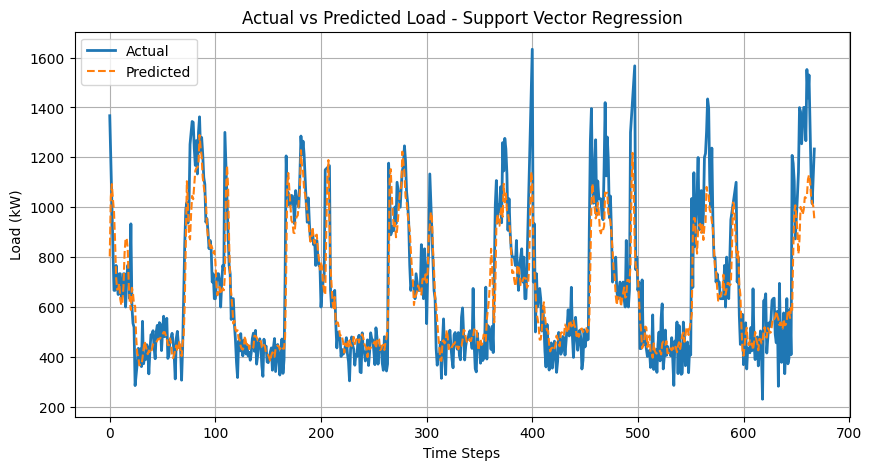


--- Training Random Forest ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

In [3]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


class ModelManager:
    def __init__(self, train_data, test_data, features_to_keep, window_size, target_step):
        self.train_data = train_data
        self.test_data = test_data
        self.features_to_keep = features_to_keep
        self.window_size = window_size
        self.target_step = target_step
        self.models = {}
        self.results = {}

    def create_rolling_features(self, data, roll_window=4):
        data = data.copy()
        data['Load_roll_mean'] = data['Load'].rolling(window=roll_window).mean()
        data['Load_roll_std'] = data['Load'].rolling(window=roll_window).std()
        data.fillna(method='bfill', inplace=True)
        return data

    def create_sliding_window(self, data):
        X, y = [], []
        for i in range(len(data) - self.window_size - self.target_step):
            X.append(data.iloc[i : i + self.window_size, 1:].values.flatten())
            y.append(data['Load'].iloc[i + self.window_size + self.target_step])
        return np.array(X), np.array(y)

    def preprocess_data(self):
        self.train_data = self.create_rolling_features(self.train_data)
        self.test_data = self.create_rolling_features(self.test_data)

        X_train, y_train = self.create_sliding_window(self.train_data)
        X_test, y_test = self.create_sliding_window(self.test_data)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test

    def train_model(self, model_name, model, param_dist, random_state, X_train, y_train):
        best_estimator = None
        best_score = float("inf")
        tscv = TimeSeriesSplit(n_splits=5)

        while True:
            random_search = RandomizedSearchCV(
                model,
                param_distributions=param_dist,
                n_iter=10,
                scoring='neg_mean_squared_error',
                cv=tscv,
                verbose=1,
                random_state=random_state,
                n_jobs=-1
            )
            random_search.fit(X_train, y_train)

            if -random_search.best_score_ < best_score:
                best_score = -random_search.best_score_
                best_estimator = random_search.best_estimator_
            else:
                break

        self.models[model_name] = best_estimator
        return best_estimator

    def predict(self, model_name, X_test, y_test):
        model = self.models.get(model_name)
        if not model:
            raise ValueError(f"Model '{model_name}' is not trained yet.")
        
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        evs = explained_variance_score(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        self.results[model_name] = {
            "y_pred": y_pred,
            "metrics": {
                "MSE": mse,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2,
                "Explained Variance": evs,
                "MAPE": mape
            }
        }
        return self.results[model_name]

    def plot_results(self, model_name, y_test):
        y_pred = self.results[model_name]["y_pred"]
        plt.figure(figsize=(10, 5))
        plt.plot(y_test, label='Actual', linewidth=2)
        plt.plot(y_pred, label='Predicted', linestyle='--')
        plt.legend()
        plt.xlabel("Time Steps")
        plt.ylabel("Load (kW)")
        plt.title(f"Actual vs Predicted Load - {model_name}")
        plt.grid()
        plt.show()


if __name__ == "__main__":
    # Load Data
    train_data = pd.read_csv("train_delta_o.csv")
    test_data = pd.read_csv("test_delta_o.csv")

    # Select Features
    features_to_keep = [
        'Load','D_1','D_2','D_3','D_4','D_5','D_6','D_7',
        'Pc_1','Pc_2','Pc_3','Pc_4','Pc_5','Pc_6','Pc_7',
        'relative_humidity', 'clearsky_dni','zenith',
        'Day','Month','D_1_h','D_2_h','D_3_h',
        'uv_index','dewpoint_temp','Hour','Minute'
    ]
    train_data = train_data[features_to_keep]
    test_data = test_data[features_to_keep]

    # Initialize Manager
    manager = ModelManager(
        train_data=train_data,
        test_data=test_data,
        features_to_keep=features_to_keep,
        window_size=4,
        target_step=0
    )

    X_train, X_test, y_train, y_test = manager.preprocess_data()

    # SVR Model
    param_dist_svr = {
        'C': [0.01, 0.1, 1, 10, 50, 100, 200],
        'epsilon': [0.001, 0.01, 0.1, 0.2, 0.5],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto'],
        'degree': [2, 3, 4],
        'coef0': [0, 0.1, 0.5]
    }
    svr_model = SVR()
    print("\n--- Training SVR ---")
    manager.train_model("Support Vector Regression", svr_model, param_dist_svr, 42, X_train, y_train)
    svr_results = manager.predict("Support Vector Regression", X_test, y_test)
    print("\nSupport Vector Regression Results:")
    print(svr_results["metrics"])
    manager.plot_results("Support Vector Regression", y_test)

    # Random Forest Model
    param_dist_rf = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }
    rf_model = RandomForestRegressor(random_state=42)
    print("\n--- Training Random Forest ---")
    manager.train_model("Random Forest", rf_model, param_dist_rf, 42, X_train, y_train)
    rf_results = manager.predict("Random Forest", X_test, y_test)
    print("\nRandom Forest Results:")
    print(rf_results["metrics"])
    manager.plot_results("Random Forest", y_test)

    # Decision Tree Model
    param_dist_dt = {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }
    dt_model = DecisionTreeRegressor(random_state=42)
    print("\n--- Training Decision Tree ---")
    manager.train_model("Decision Tree", dt_model, param_dist_dt, 42, X_train, y_train)
    dt_results = manager.predict("Decision Tree", X_test, y_test)
    print("\nDecision Tree Results:")
    print(dt_results["metrics"])
    manager.plot_results("Decision Tree", y_test)


In [10]:

test_data['Year'] = 2024
test_data['Date'] = pd.to_datetime(test_data[['Year', 'Month', 'Day']])

dates = test_data['Date'][manager.window_size + manager.target_step:].reset_index(drop=True)

daily_mape_results = {}

for model_name, result in manager.results.items():
    y_pred = result['y_pred']
    y_test_df = pd.DataFrame({
        'Date': dates,
        'y_test': y_test,
        'y_pred': y_pred
    })

    daily_mape = y_test_df.groupby('Date').apply(
        lambda x: np.mean(np.abs((x['y_test'] - x['y_pred']) / x['y_test'])) * 100
    )
    daily_mape_results[model_name] = daily_mape

mape_summary = pd.DataFrame(daily_mape_results)
mape_summary.reset_index(inplace=True)
mape_summary


,Date,Model 1,Model 2,Model 3,Model 4,Model 5
0,2024-11-14,17.263938,17.076880,17.522369,16.666380,17.048032
1,2024-11-15,10.597690,10.898644,11.321821,10.609597,10.449657
2,2024-11-16,12.374174,12.974682,12.235192,12.049857,12.523313
3,2024-11-19,21.024543,21.303184,21.305766,20.700578,20.849474
4,2024-11-20,13.494118,13.612777,12.993491,12.760181,12.749410
5,2024-11-21,15.883879,16.395872,16.436964,15.487651,15.444786
6,2024-11-22,19.620784,19.317452,19.174309,18.109202,18.167970


In [11]:
y_pred3 = manager.results["Model 3"]["y_pred"]
y_pred3

array([ 779.7670491 ,  762.52460369,  748.30561976,  753.23669417,
        738.82059438,  748.01756615,  771.04207984,  748.26933045,
        750.87819925,  710.25337618,  703.69893466,  732.98763381,
        821.11730011, 1036.47553137, 1053.10060697, 1176.23013572,
       1217.66631926, 1130.75341333,  889.61160461,  797.86168301,
        646.3352209 ,  574.45823651,  549.94101028,  537.85309749,
        515.37439059,  584.28940838,  514.59584971,  522.61859899,
        480.34692072,  447.68853212,  435.36678729,  430.3216486 ,
        414.70398485,  420.2332175 ,  418.19141419,  418.35281943,
        443.65488711,  437.08429182,  444.40123997,  441.17654311,
        463.82039305,  469.82544479,  470.77014595,  471.10377246,
        477.543576  ,  485.18694236,  495.58844614,  493.31392738,
        485.08266741,  489.26047889,  503.63660022,  508.51586463,
        517.18508471,  514.03801847,  497.70195102,  490.73718609,
        482.52413799,  469.86392532,  485.72433634,  480.60354

## Random Forest

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Random Forest Regressor Results:
MSE: 19329.1698
RMSE: 139.0294
MAE: 94.4580
R2: 0.7889
Explained Variance: 0.7922
MAPE: 15.0161


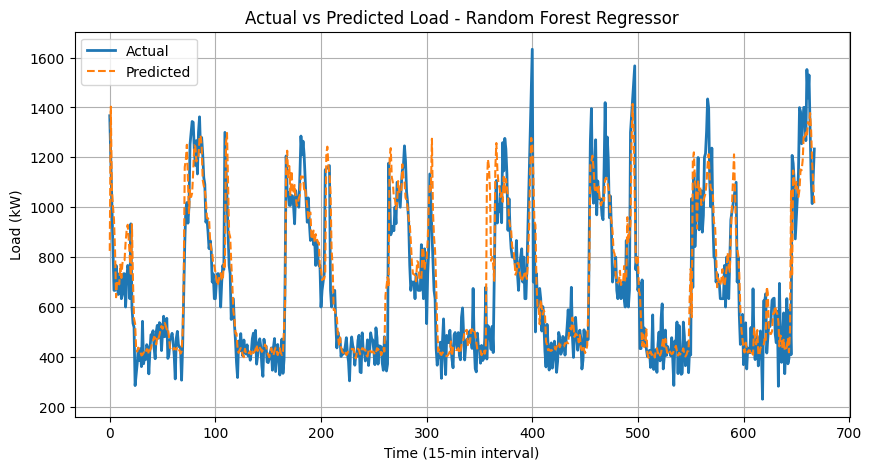

In [9]:
from sklearn.ensemble import RandomForestRegressor

param_dist_rf = {
    'n_estimators': [50, 100, 200],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Khởi tạo model Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Train model
manager.train_model(
    model_name="Random Forest Regressor",
    model=rf_model,
    param_dist=param_dist_rf,
    random_state=42,
    X_train=X_train,
    y_train=y_train
)

# Dự đoán
rf_results = manager.predict("Random Forest Regressor", X_test, y_test)
print("\nRandom Forest Regressor Results:")
for k, v in rf_results["metrics"].items():
    print(f"{k}: {v:.4f}")

# Plot
manager.plot_results("Random Forest Regressor", y_test)



## Gradient Boosting Regressor (Sklearn)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Gradient Boosting Regressor Results:
MSE: 17024.3127
RMSE: 130.4772
MAE: 92.5359
R2: 0.8141
Explained Variance: 0.8154
MAPE: 14.6685


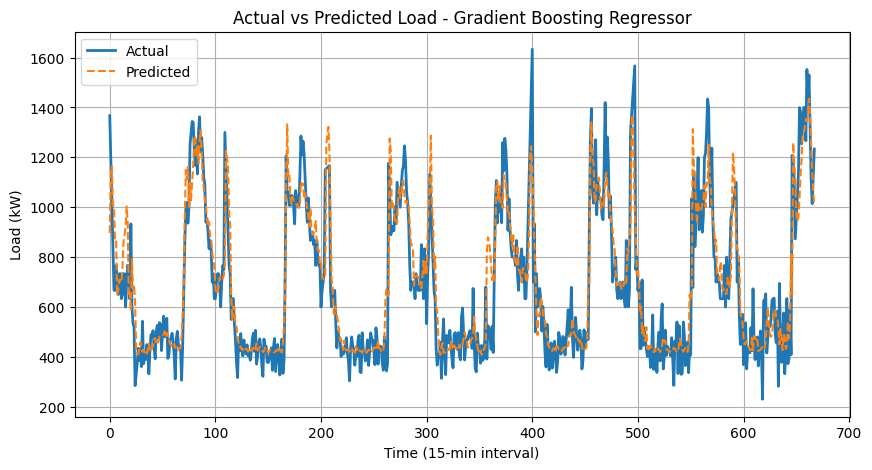

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

param_dist_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'loss': ['squared_error', 'absolute_error']
}

# Khởi tạo Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(random_state=42)

# Train model
manager.train_model(
    model_name="Gradient Boosting Regressor",
    model=gbr_model,
    param_dist=param_dist_gbr,
    random_state=42,
    X_train=X_train,
    y_train=y_train
)

# Dự đoán
gbr_results = manager.predict("Gradient Boosting Regressor", X_test, y_test)
print("\nGradient Boosting Regressor Results:")
for k, v in gbr_results["metrics"].items():
    print(f"{k}: {v:.4f}")

# Plot
manager.plot_results("Gradient Boosting Regressor", y_test)


## XGBoost Model

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits

XGBoost Regressor Results:
MSE: 16841.2241
RMSE: 129.7737
MAE: 91.5627
R2: 0.8161
Explained Variance: 0.8172
MAPE: 14.5676


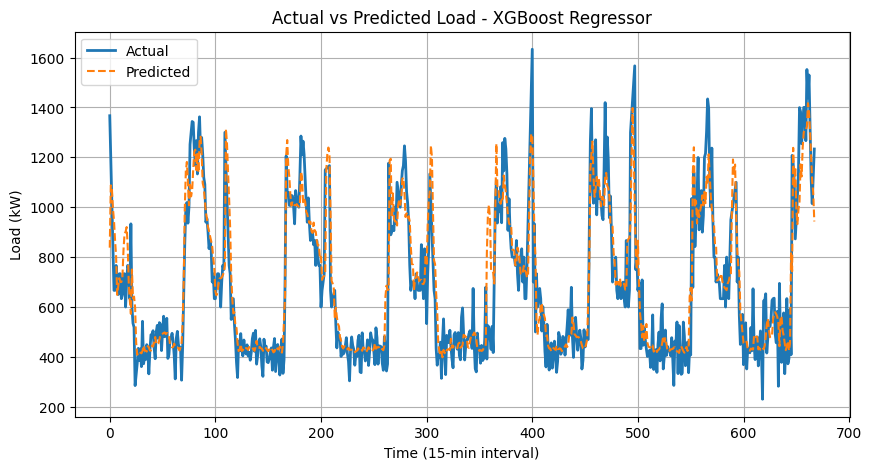

In [11]:
from xgboost import XGBRegressor

param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 1],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Khởi tạo XGBRegressor
xgb_model = XGBRegressor(random_state=42, verbosity=0)

# Train model
manager.train_model(
    model_name="XGBoost Regressor",
    model=xgb_model,
    param_dist=param_dist_xgb,
    random_state=42,
    X_train=X_train,
    y_train=y_train
)

# Dự đoán
xgb_results = manager.predict("XGBoost Regressor", X_test, y_test)
print("\nXGBoost Regressor Results:")
for k, v in xgb_results["metrics"].items():
    print(f"{k}: {v:.4f}")

# Plot
manager.plot_results("XGBoost Regressor", y_test)



## LightGBM 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13704
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18042
[LightGBM] [Info] Total Bins 13704
[LightGBM] [Info] Number of data points in the train set: 641, number of used features: 112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

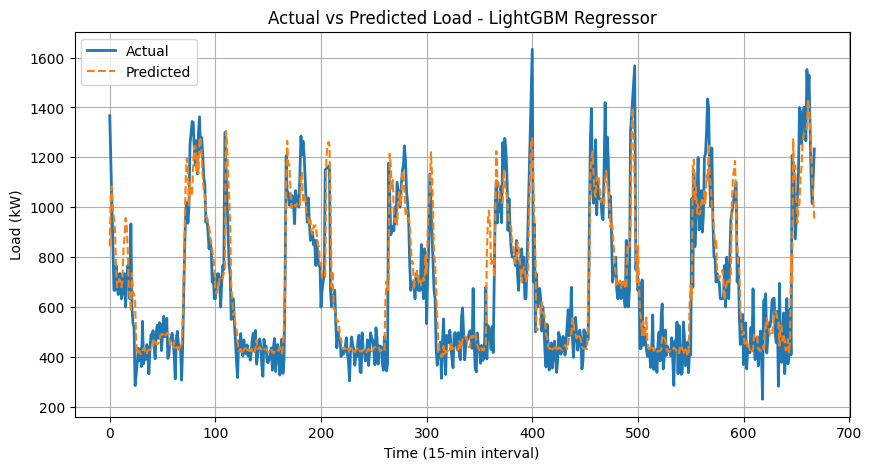

In [12]:
import lightgbm as lgb

param_dist_lgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'max_depth': [3, 5, 7, -1],   # -1: không giới hạn
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Khởi tạo LightGBM Regressor
lgb_model = lgb.LGBMRegressor(random_state=42)

# Train model
manager.train_model(
    model_name="LightGBM Regressor",
    model=lgb_model,
    param_dist=param_dist_lgb,
    random_state=42,
    X_train=X_train,
    y_train=y_train
)

# Dự đoán
lgb_results = manager.predict("LightGBM Regressor", X_test, y_test)
print("\nLightGBM Regressor Results:")
for k, v in lgb_results["metrics"].items():
    print(f"{k}: {v:.4f}")

# Plot
manager.plot_results("LightGBM Regressor", y_test)



## CatBoost

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits

CatBoost Regressor Results:
MSE: 15455.9732
RMSE: 124.3221
MAE: 88.0189
R2: 0.8312
Explained Variance: 0.8312
MAPE: 13.8190


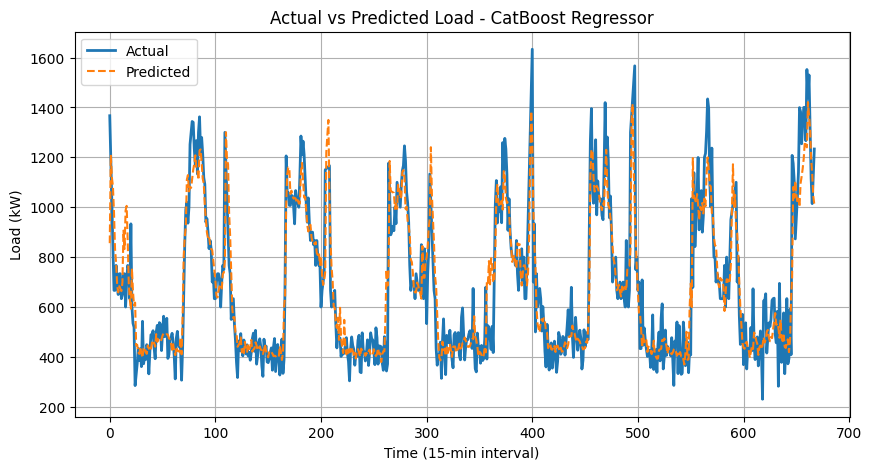

In [26]:
from catboost import CatBoostRegressor

# Giữ random_state=42 tại CatBoostRegressor
cat_model = CatBoostRegressor(
    silent=True,
    random_state=42,  # Dùng random_state
    # KHÔNG dùng random_seed ở đây
)

# Bỏ random_seed trong param_dist_cat
param_dist_cat = {
    'iterations': [300, 500, 800, 1000],
    'depth': [3, 5, 7, 9],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 10],
    'subsample': [0.5, 0.7, 0.8, 1.0],
    'bagging_temperature': [0, 0.5, 1, 2],
    'random_strength': [1, 2, 5, 10],

}

# Sau đó, bạn vẫn có thể gọi train_model như bình thường
manager.train_model(
    model_name="CatBoost Regressor",
    model=cat_model,
    param_dist=param_dist_cat,
    random_state=42,
    X_train=X_train,
    y_train=y_train
)

# Dự đoán
cat_results = manager.predict("CatBoost Regressor", X_test, y_test)
print("\nCatBoost Regressor Results:")
for k, v in cat_results["metrics"].items():
    print(f"{k}: {v:.4f}")

# Plot
manager.plot_results("CatBoost Regressor", y_test)


In [14]:
import pandas as pd

# Danh sách tên mô hình mà bạn đã huấn luyện và dự đoán
model_names = [
    "Random Forest Regressor",
    "Gradient Boosting Regressor",
    "XGBoost Regressor",
    "LightGBM Regressor",
    "CatBoost Regressor"
]

# Tạo danh sách để lưu kết quả tóm gọn
summary_rows = []

# Duyệt qua từng model_name, lấy metrics từ manager.results
for model_name in model_names:
    metrics = manager.results[model_name]["metrics"]  # {"MSE":..., "RMSE":..., ...}
    summary_rows.append([
        model_name,
        metrics["MSE"],
        metrics["RMSE"],
        metrics["MAE"],
        metrics["R2"],
        metrics["Explained Variance"],
        metrics["MAPE"]
    ])

# Tạo DataFrame tóm gọn
df_summary = pd.DataFrame(
    summary_rows, 
    columns=["Model", "MSE", "RMSE", "MAE", "R2", "Explained Variance", "MAPE"]
)

# In kết quả
print("========== SUMMARY RESULTS ==========")
print(df_summary)


========== SUMMARY RESULTS ==========
                         Model           MSE        RMSE        MAE        R2  \
0      Random Forest Regressor  19329.169839  139.029385  94.457952  0.788919   
1  Gradient Boosting Regressor  17024.312651  130.477250  92.535907  0.814089   
2            XGBoost Regressor  16841.224059  129.773742  91.562718  0.816089   
3           LightGBM Regressor  16956.582526  130.217443  92.628758  0.814829   
4           CatBoost Regressor  16487.896428  128.405204  90.458373  0.819947   

   Explained Variance       MAPE  
0            0.792211  15.016059  
1            0.815401  14.668517  
2            0.817156  14.567594  
3            0.816001  14.693218  
4            0.820417  14.254697  


## SVM

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Support Vector Regression Results:
{'MSE': 20322.234331625372, 'RMSE': 142.55607434138108, 'MAE': 96.57188704167422, 'R2': 0.7780748751636191, 'Explained Variance': 0.7847592929567948, 'MAPE': 14.418672040472934}


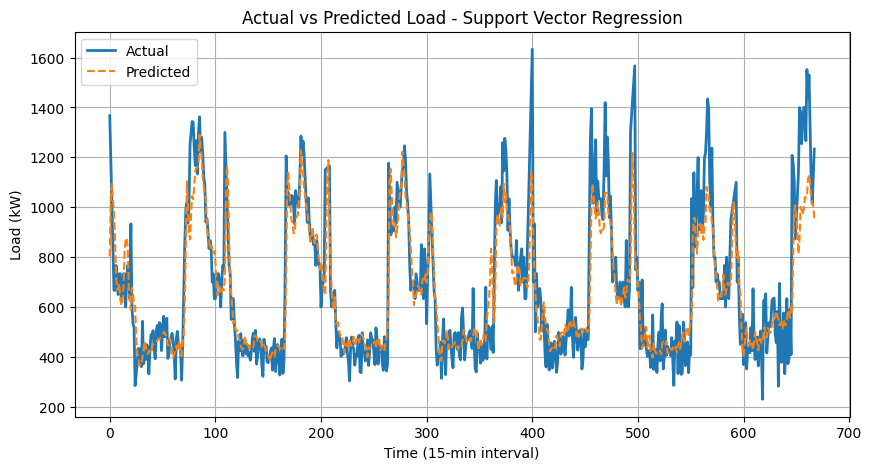

In [36]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class ModelManager:
    def __init__(self, train_data, test_data, features_to_keep, window_size, target_step):
        self.train_data = train_data
        self.test_data = test_data
        self.features_to_keep = features_to_keep
        self.window_size = window_size
        self.target_step = target_step
        self.models = {}
        self.results = {}

    def create_rolling_features(self, data, roll_window=4):
        """
        Ví dụ thêm: tính rolling mean và rolling std cho cột 'Load'.
        Có thể mở rộng cho các cột khác.
        """
        data = data.copy()
        data['Load_roll_mean'] = data['Load'].rolling(window=roll_window).mean()
        data['Load_roll_std'] = data['Load'].rolling(window=roll_window).std()
        data.fillna(method='bfill', inplace=True)
        return data

    def create_sliding_window(self, data):
        X, y = [], []
        for i in range(len(data) - self.window_size - self.target_step):
            # Lấy tất cả cột trừ cột đầu tiên (nếu cột đầu tiên là time stamp).
            # Điều chỉnh cho đúng thứ tự cột nếu cần.
            X.append(data.iloc[i:i+self.window_size, 1:].values.flatten())  
            y.append(data['Load'].iloc[i+self.window_size+self.target_step])  
        return np.array(X), np.array(y)

    def preprocess_data(self):
        # Thêm rolling features
        self.train_data = self.create_rolling_features(self.train_data)
        self.test_data = self.create_rolling_features(self.test_data)

        X_train, y_train = self.create_sliding_window(self.train_data)
        X_test, y_test = self.create_sliding_window(self.test_data)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test

    def train_model(self, model_name, model, param_dist, random_state, X_train, y_train):
        best_estimator = None
        best_score = float("inf")

        # Dùng TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=5)

        while True:
            random_search = RandomizedSearchCV(
                model,
                param_distributions=param_dist,
                n_iter=10,
                scoring='neg_mean_squared_error',
                cv=tscv,
                verbose=1,
                random_state=random_state,
                n_jobs=-1
            )
            random_search.fit(X_train, y_train)

            if -random_search.best_score_ < best_score:
                best_score = -random_search.best_score_
                best_estimator = random_search.best_estimator_
            else:
                # Nếu không cải thiện thì dừng
                break

        self.models[model_name] = best_estimator
        return best_estimator

    def predict(self, model_name, X_test, y_test):
        model = self.models.get(model_name)
        if not model:
            raise ValueError(f"Model '{model_name}' is not trained yet.")
        
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        evs = explained_variance_score(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        self.results[model_name] = {
            "y_pred": y_pred,
            "metrics": {
                "MSE": mse,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2,
                "Explained Variance": evs,
                "MAPE": mape
            }
        }
        return self.results[model_name]

    def plot_results(self, model_name, y_test):
        y_pred = self.results[model_name]["y_pred"]
        plt.figure(figsize=(10, 5))
        plt.plot(y_test, label='Actual', linewidth=2)
        plt.plot(y_pred, label='Predicted', linestyle='--')
        plt.legend()
        plt.xlabel("Time (15-min interval)")
        plt.ylabel("Load (kW)")
        plt.title(f"Actual vs Predicted Load - {model_name}")
        plt.grid()
        plt.show()

if __name__ == "__main__":
    # Load data
    train_data = pd.read_csv("train_delta_o.csv")
    test_data = pd.read_csv("test_delta_o.csv")
    
    features_to_keep = [
        'Load','D_1','D_2','D_3','D_4','D_5','D_6','D_7','Pc_1','Pc_2','Pc_3','Pc_4','Pc_5','Pc_6','Pc_7',
        'relative_humidity', 'clearsky_dni','zenith',
        'Day','Month','D_1_h','D_2_h','D_3_h',
        'uv_index','dewpoint_temp','Hour','Minute'
    ]
    train_data = train_data[features_to_keep]
    test_data = test_data[features_to_keep]

    # Khởi tạo manager
    manager = ModelManager(
        train_data=train_data,
        test_data=test_data,
        features_to_keep=features_to_keep,
        window_size=4,
        target_step=0
    )
    X_train, X_test, y_train, y_test = manager.preprocess_data()

    # Cấu hình tham số rộng hơn
    param_dist_svr = {
        'C': [0.01, 0.1, 1, 10, 50, 100, 200],
        'epsilon': [0.001, 0.01, 0.1, 0.2, 0.5],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto'],
        'degree': [2, 3, 4],
        'coef0': [0, 0.1, 0.5]
    }

    svr_model = SVR()
    manager.train_model("Support Vector Regression", svr_model, param_dist_svr, random_state=42, X_train=X_train, y_train=y_train)

    # Dự đoán và plot
    svr_results = manager.predict("Support Vector Regression", X_test, y_test)
    print("\nSupport Vector Regression Results:")
    print(svr_results["metrics"])
    manager.plot_results("Support Vector Regression", y_test)


## Extreme learning machine (ELM)

In [30]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class ExtremeLearningMachine:
    def __init__(self, n_hidden_neurons, activation='sigmoid'):
        self.n_hidden_neurons = n_hidden_neurons
        self.activation = activation
        self.input_weights = None
        self.biases = None
        self.beta = None

    def _activation_function(self, X):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-X))
        elif self.activation == 'tanh':
            return np.tanh(X)
        elif self.activation == 'relu':
            return np.maximum(0, X)
        else:
            raise ValueError("Unsupported activation function")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.input_weights = np.random.normal(size=(n_features, self.n_hidden_neurons))
        self.biases = np.random.normal(size=(self.n_hidden_neurons,))
        
        H = self._activation_function(np.dot(X, self.input_weights) + self.biases)
        self.beta = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        H = self._activation_function(np.dot(X, self.input_weights) + self.biases)
        return np.dot(H, self.beta)

# Example Usage
window_size = 4
target_step = 0

# Prepare sliding window data (same as above)
X_train, y_train = create_sliding_window(train_data, window_size, target_step)
X_test, y_test = create_sliding_window(test_data, window_size, target_step)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train ELM
elm = ExtremeLearningMachine(n_hidden_neurons=100, activation='sigmoid')
elm.fit(X_train_scaled, y_train)

# Predict
y_pred_elm = elm.predict(X_test_scaled)

# Evaluate
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"Results for {model_name}:")
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R2:", r2)
    print("MAPE:", mape)
    return mse, rmse, mae, r2, mape

elm_results = evaluate_model(y_test, y_pred_elm, "Manual ELM")


Results for Manual ELM:
MSE: 39766.6752591682
RMSE: 199.41583502612875
MAE: 140.2929075959388
R2: 0.565735527540643
MAPE: 21.434029254030193


## Gradient Boosting

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   4.6s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   5.8s
[CV] END learning_rate=0.05, max_depth=7, min_samples_leaf=4, min_samples_split=5, n_estimators=100, subsample=0.8; total time=   6.0s
[CV] END learning_rate=0.05, max_depth=7, min_samples_leaf=4, min_samples_split=5, n_estimators=100, subsample=0.8; total time=   6.1s
[CV] END learning_rate=0.05, max_depth=7, min_samples_leaf=4, min_samples_split=5, n_estimators=100, subsample=0.8; total time=   6.1s
[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.9; total time=   6.4s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=1.0; total time=

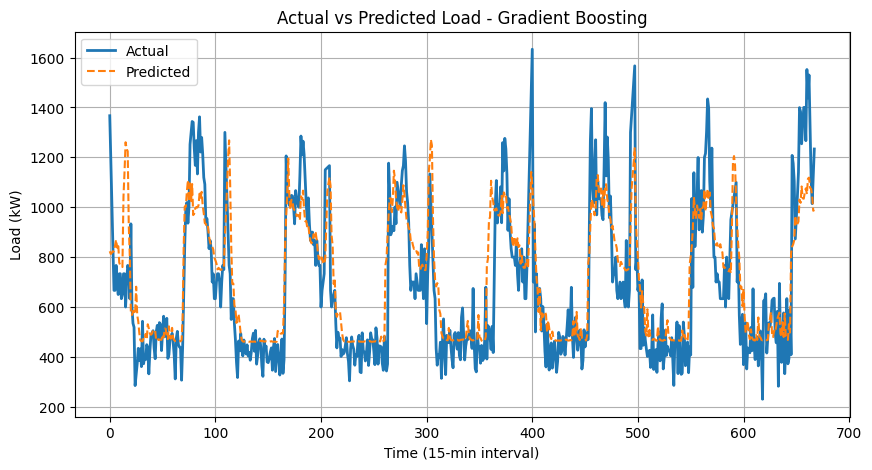

In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

class ModelManager:
    def __init__(self, train_data, test_data, features_to_keep, window_size, target_step):
        self.train_data = train_data
        self.test_data = test_data
        self.features_to_keep = features_to_keep
        self.window_size = window_size
        self.target_step = target_step
        self.models = {}  # Store trained models
        self.results = {}  # Store results like y_pred for each model
    
    def create_sliding_window(self, data):
        X, y = [], []
        for i in range(len(data) - self.window_size - self.target_step):
            X.append(data.iloc[i:i+self.window_size, 1:].values.flatten())  
            y.append(data['Load'].iloc[i+self.window_size+self.target_step])  
        return np.array(X), np.array(y)
    
    def preprocess_data(self):
        X_train, y_train = self.create_sliding_window(self.train_data)
        X_test, y_test = self.create_sliding_window(self.test_data)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test
    
    def train_model(self, model_name, model, param_dist, random_state, X_train, y_train):
        random_search = RandomizedSearchCV(
            model, param_distributions=param_dist, n_iter=100,  # Increased iterations for better exploration
            scoring='neg_mean_squared_error', cv=3, verbose=2, random_state=random_state, n_jobs=-1
        )
        random_search.fit(X_train, y_train)
        self.models[model_name] = random_search.best_estimator_
        return random_search.best_estimator_
    
    def predict(self, model_name, X_test, y_test):
        model = self.models.get(model_name)
        if not model:
            raise ValueError(f"Model '{model_name}' is not trained yet.")
        
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        evs = explained_variance_score(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        self.results[model_name] = {
            "y_pred": y_pred,
            "metrics": {
                "MSE": mse,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2,
                "Explained Variance": evs,
                "MAPE": mape
            }
        }
        return self.results[model_name]
    
    def plot_results(self, model_name, y_test):
        y_pred = self.results[model_name]["y_pred"]
        plt.figure(figsize=(10, 5))
        plt.plot(y_test, label='Actual', linewidth=2)
        plt.plot(y_pred, label='Predicted', linestyle='--')
        plt.legend()
        plt.xlabel("Time (15-min interval)")
        plt.ylabel("Load (kW)")
        plt.title(f"Actual vs Predicted Load - {model_name}")
        plt.grid()
        plt.show()

if __name__ == "__main__":
    # Load data
    train_data = pd.read_csv("train_delta_o.csv")
    test_data = pd.read_csv("test_delta_o.csv")
    
    features_to_keep = ['Load','D_1','D_2','D_3','D_4','D_5','D_6','D_7','Pc_1','Pc_2','Pc_3','Pc_4','Pc_5','Pc_6','Pc_7',
                        'relative_humidity', 'clearsky_dni','zenith',
                        'Day','Month','D_1_h','D_2_h','D_3_h',
                        'uv_index','dewpoint_temp','Hour','Minute']
    train_data = train_data[features_to_keep]
    test_data = test_data[features_to_keep]

    # Initialize manager
    manager = ModelManager(train_data, test_data, features_to_keep, window_size=4, target_step=0)
    X_train, X_test, y_train, y_test = manager.preprocess_data()

    # Gradient Boosting Model
    param_dist_gb = {
        'n_estimators': [100, 200, 300],  # Expanded options
        'learning_rate': [0.01, 0.05, 0.1],  # Broader range
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 0.9, 1.0]  # Added subsample for regularization
    }
    gb_model = GradientBoostingRegressor(random_state=42, validation_fraction=0.1, n_iter_no_change=10)  # Early stopping
    best_gb = manager.train_model("Gradient Boosting", gb_model, param_dist_gb, random_state=42, X_train=X_train, y_train=y_train)
    gb_results = manager.predict("Gradient Boosting", X_test, y_test)
    print("\nGradient Boosting Results:")
    print(gb_results)
    manager.plot_results("Gradient Boosting", y_test)

## Train multiple models

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt
import warnings
import time

warnings.filterwarnings('ignore')

class ModelManager:
    def __init__(self, train_data, test_data, features_to_keep, window_size, target_step):
        self.train_data = train_data
        self.test_data = test_data
        self.features_to_keep = features_to_keep
        self.window_size = window_size
        self.target_step = target_step
        self.models = {}  # Store trained models
        self.results = {}  # Store results like y_pred for each model

    def create_sliding_window(self, data):
        X, y = [], []
        for i in range(len(data) - self.window_size - self.target_step):
            X.append(data.iloc[i:i+self.window_size, 1:].values.flatten())  
            y.append(data['Load'].iloc[i+self.window_size+self.target_step])  
        return np.array(X), np.array(y)

    def preprocess_data(self):
        X_train, y_train = self.create_sliding_window(self.train_data)
        X_test, y_test = self.create_sliding_window(self.test_data)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test

    def train_model_with_timeout(self, model_name, model, param_dist, random_state, X_train, y_train, timeout=300):
        start_time = time.time()
        best_estimator = None
        best_score = float("inf")

        while time.time() - start_time < timeout:
            random_search = RandomizedSearchCV(
                model, param_distributions=param_dist, n_iter=10,
                scoring='neg_mean_squared_error', cv=3, verbose=1, random_state=random_state, n_jobs=-1
            )
            random_search.fit(X_train, y_train)

            if -random_search.best_score_ < best_score:
                best_score = -random_search.best_score_
                best_estimator = random_search.best_estimator_

        self.models[model_name] = best_estimator
        return best_estimator

    def predict(self, model_name, X_test, y_test):
        model = self.models.get(model_name)
        if not model:
            raise ValueError(f"Model '{model_name}' is not trained yet.")
        
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        evs = explained_variance_score(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        self.results[model_name] = {
            "y_pred": y_pred,
            "metrics": {
                "MSE": mse,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2,
                "Explained Variance": evs,
                "MAPE": mape
            }
        }
        return self.results[model_name]

    def ensemble_predict(self, X_test, y_test):
        predictions = []
        for model_name in self.models:
            model = self.models[model_name]
            predictions.append(model.predict(X_test))
        
        ensemble_prediction = np.mean(predictions, axis=0)
        mse = mean_squared_error(y_test, ensemble_prediction)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, ensemble_prediction)
        r2 = r2_score(y_test, ensemble_prediction)
        evs = explained_variance_score(y_test, ensemble_prediction)
        mape = np.mean(np.abs((y_test - ensemble_prediction) / y_test)) * 100

        self.results["Ensemble"] = {
            "y_pred": ensemble_prediction,
            "metrics": {
                "MSE": mse,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2,
                "Explained Variance": evs,
                "MAPE": mape
            }
        }
        return self.results["Ensemble"]

    def plot_results(self, model_name, y_test):
        y_pred = self.results[model_name]["y_pred"]
        plt.figure(figsize=(10, 5))
        plt.plot(y_test, label='Actual', linewidth=2)
        plt.plot(y_pred, label='Predicted', linestyle='--')
        plt.legend()
        plt.xlabel("Time (15-min interval)")
        plt.ylabel("Load (kW)")
        plt.title(f"Actual vs Predicted Load - {model_name}")
        plt.grid()
        plt.show()

if __name__ == "__main__":
    # Load data
    train_data = pd.read_csv("train_delta_o.csv")
    test_data = pd.read_csv("test_delta_o.csv")
    
    features_to_keep = ['Load','D_1','D_2','D_3','D_4','D_5','D_6','D_7','Pc_1','Pc_2','Pc_3','Pc_4','Pc_5','Pc_6','Pc_7',
                        'relative_humidity', 'clearsky_dni','zenith',
                        'Day','Month','D_1_h','D_2_h','D_3_h',
                        'uv_index','dewpoint_temp','Hour','Minute']
    train_data = train_data[features_to_keep]
    test_data = test_data[features_to_keep]

    # Initialize manager
    manager = ModelManager(train_data, test_data, features_to_keep, window_size=4, target_step=0)
    X_train, X_test, y_train, y_test = manager.preprocess_data()

    # Random Forest Model
    param_dist_rf = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    rf_model = RandomForestRegressor(random_state=42)
    manager.train_model_with_timeout("Random Forest", rf_model, param_dist_rf, random_state=42, X_train=X_train, y_train=y_train, timeout=300)

    # Gradient Boosting Model
    param_dist_gb = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    gb_model = GradientBoostingRegressor(random_state=42)
    manager.train_model_with_timeout("Gradient Boosting", gb_model, param_dist_gb, random_state=42, X_train=X_train, y_train=y_train, timeout=300)

    # Bagging Regressor Model
    param_dist_bagging = {
        'n_estimators': [10, 50, 100],
        'max_samples': [0.6, 0.8, 1.0],
        'max_features': [0.6, 0.8, 1.0]
    }
    bagging_model = BaggingRegressor(random_state=42)
    manager.train_model_with_timeout("Bagging", bagging_model, param_dist_bagging, random_state=42, X_train=X_train, y_train=y_train, timeout=300)

    # Ensemble Prediction
    ensemble_results = manager.ensemble_predict(X_test, y_test)
    print("\nEnsemble Results:")
    print(ensemble_results)
    manager.plot_results("Ensemble", y_test)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each

KeyboardInterrupt: 